<a href="https://colab.research.google.com/github/ese-ada-lovelace-2024/Gems4-draupnir/blob/main/IanSandbox_PBU1500data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot tqdm pycm

In [3]:
## Imports
import os, random
import numpy as np

#DeepLearning Torch
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import ShuffleSplit

from livelossplot import PlotLosses
from tqdm import tqdm
from pycm import *

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#randomizer
def set_seed(seed):
  """
  Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  torch.backends.cudnn.benchmark = False # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. Useful when inputs do not change size
  torch.backends.cudnn.enabled = False

  return True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-40GB!


In [ ]:
directory = "/content/drive/MyDrive/GEMS4-CCS/train_data_set"
file_list = np.sort([f for f in os.listdir(directory) if f.endswith('.npz')])

thickness = np.array([0, 0])
for i, file_name in enumerate(file_list, ):
    file_path = os.path.join(directory, file_name)

    with np.load(file_path) as data:
        if i == 1:
            thickness[0] = data['porosity'].shape[0]
            thickness[1] = data['porosity'].shape[0]

            for j, key in enumerate(data.keys()):
                print(f"Data {j}: {key}, shape {data[key].shape}")
            print()

        else:
            if thickness[0] > data['porosity'].shape[0]:
                thickness[0] = data['porosity'].shape[0]
            if thickness[1] < data['porosity'].shape[0]:
                thickness[1] = data['porosity'].shape[0]

In [18]:
#shortest shape :5,200,24
#longest shape: 96,200,24

class Preprocessor(Dataset):
    def __init__(self, split="train", file_num=None, target='pressure_buildup',
                 normalize=True, pad_mode='zero'):

        if split == "train":
            directory = "/content/drive/MyDrive/GEMS4-CCS/train_data_set"
        elif split == "val":
            directory = "/content/drive/MyDrive/GEMS4-CCS/val_data_set"

        else:
            raise ValueError("split should be either 'train', 'val', or 'test'")

        self.file_paths = [os.path.join(directory, f)
                           for f in np.sort([f for f in os.listdir(directory) if
                                             f.endswith('.npz')])]
        if file_num is not None:
            self.file_paths = self.file_paths[:file_num]

        if target not in ["pressure_buildup", "gas_saturation"]:
            raise ValueError("target should be either 'pressure_buildup' or 'gas_saturation'")
        else:
            self.target = target
        self.normalize = normalize
        self.pad_mode = pad_mode

    def __len__(self):
        return len(self.file_paths)

    def __str__(self):
        return (f"ReservoirDataset containing {len(self)} samples.\n"
                f"Target variable: {self.target}\n"
                f"Normalization applied: {'Yes' if self.normalize else 'No'}\n"
                f"Input shape per sample: 96x200 with 24 channels\n"
                f"Target shape per sample: 96x200 with 24 time steps\n"
                f"Files are stored in: {os.path.dirname(self.file_paths[0]) if self.file_paths else 'No files found'}")

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        data = np.load(file_path)

        inputs = np.zeros((96, 200, 24), dtype=np.float32)

        #input channels definition
        inputs[:, :, 0] = self._pad_array(data['perm_r'], (96, 200))
        inputs[:, :, 1] = self._pad_array(data['perm_z'], (96, 200))
        inputs[:, :, 2] = self._pad_array(data['porosity'], (96, 200))
        inputs[:, :, 3] = self._create_perforation_mask(data['perf_interval'],
                                                       (96, 200))
        inputs[:, :, 4] = self._pad_array(np.full((data["porosity"].shape), data['temperature']), (96, 200))
        inputs[:, :, 5] = self._pad_array(np.full((data["porosity"].shape), data['Swi']), (96, 200))
        inputs[:, :, 6] = self._pad_array(np.full((data["porosity"].shape), data['lam']), (96, 200))
        inputs[:, :, 7] = self._pad_array(np.full((data["porosity"].shape), data['inj_rate']), (96, 200))

        for i in range(5):
            inputs[:, :, 8 + i] = inputs[:, :, 0] # perm_r replication
            inputs[:, :, 13 + i] = inputs[:, :, 1] # perm_z replication

        for i in range(4):
            inputs[:, :, 18 + i] = inputs[:, :, 2] # porosity replication

        for i in range(2):
            inputs[:, :, 22 + i] = inputs[:, :, 3] # perf replication


        target_data = data[self.target]
        target_original = target_data.copy()
        target_array = np.zeros((96, 200, 24), dtype=np.float32)
        for i in range(24):
            target_slice = target_data[..., i]
            if self.normalize and self.target == 'pressure_buildup':
                target_slice = self._normalize_data(target_data[..., i])
            target_array[:, :, i] = self._pad_array(target_slice, (96, 200))

        return {
            "inputs": torch.from_numpy(inputs).permute(2, 0, 1),
            "target": torch.from_numpy(target_array).permute(2, 0, 1),
            "original_height": target_data.shape[0] ,
            "original_target": torch.from_numpy(target_original).permute(2, 0, 1)  # <== Add this back
        }

    def _normalize_data(self, array):
        mean = array.mean()
        std = array.std()
        if std > 0:
            return (array - mean) / std
        return array - mean

    def _pad_array(self, array, target_shape):
        pad_width = [(0, max(0, target - array.shape[i])) for i, target in enumerate(target_shape)]
        if self.pad_mode == "zero":
            return np.pad(array, pad_width, mode='constant', constant_values=0)
        elif self.pad_mode == "mean":
            original_mean = np.mean(array)
            return np.pad(array, pad_width, mode='constant', constant_values=original_mean)
            #return np.pad(array, pad_width, mode='mean')
        else:
            raise ValueError("pad_mode should be either 'zero' or 'mean'")

    def _create_perforation_mask(self, perf_interval, shape):
        mask = np.zeros(shape, dtype=np.float32)
        z_start, z_end = perf_interval
        mask[z_start:z_end, :50] = 1
        return mask

In [8]:
train_data = Preprocessor(split="train", file_num=100, target='pressure_buildup', pad_mode="zero")
print(train_data)

ReservoirDataset containing 100 samples.
Target variable: pressure_buildup
Normalization applied: Yes
Input shape per sample: 96x200 with 24 channels
Target shape per sample: 96x200 with 24 time steps
Files are stored in: /content/drive/MyDrive/GEMS4-CCS/train_data_set


In [9]:
# Load the raw data from the first file
import numpy as np
npz_path = train_data.file_paths[0]
raw_data = np.load(npz_path)

porosity = raw_data['porosity']
perm_r = raw_data['perm_r']
perm_z = raw_data['perm_z']
perf_interval = raw_data['perf_interval']
temperature = np.full_like(porosity, raw_data['temperature'])
gas_saturation = raw_data['gas_saturation'][:, :, -1]  # last time step


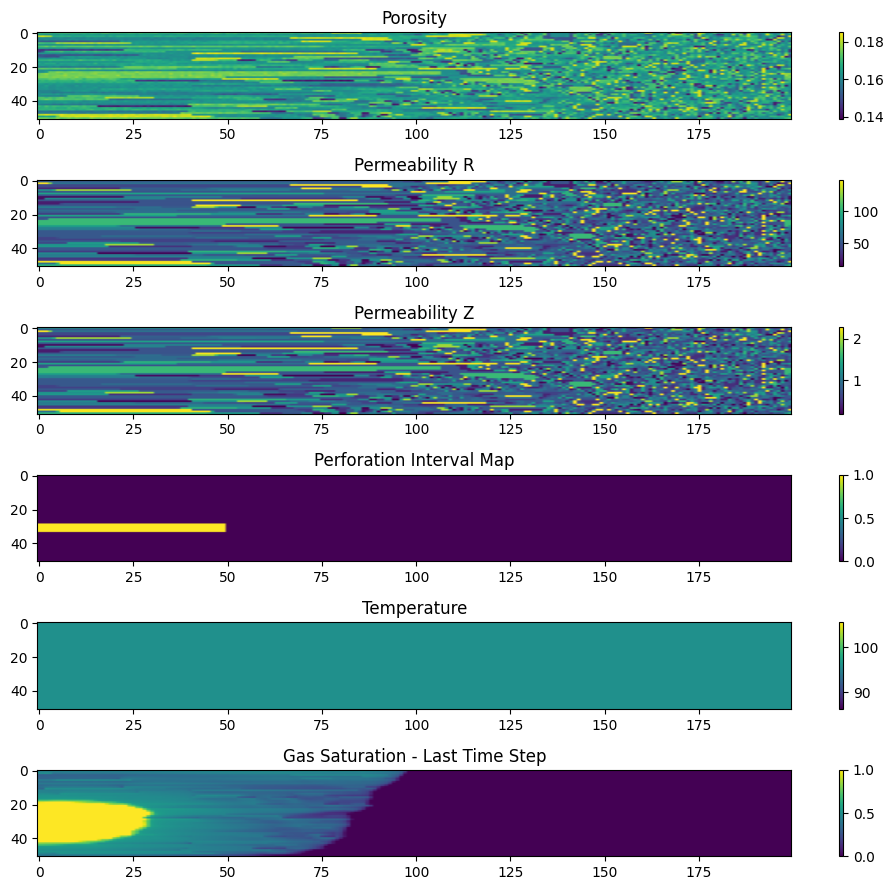

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 9))

plt.subplot(6, 1, 1)
plt.imshow(porosity, aspect='auto')
plt.colorbar()
plt.title('Porosity')

plt.subplot(6, 1, 2)
plt.imshow(perm_r, aspect='auto')
plt.colorbar()
plt.title('Permeability R')

plt.subplot(6, 1, 3)
plt.imshow(perm_z, aspect='auto')
plt.colorbar()
plt.title('Permeability Z')

plt.subplot(6, 1, 4)
# Create a mask image for the perf_interval
perf_mask = np.zeros_like(porosity)
z_start, z_end = perf_interval
perf_mask[z_start:z_end, :50] = 1
plt.imshow(perf_mask, aspect='auto')
plt.colorbar()
plt.title('Perforation Interval Map')

plt.subplot(6, 1, 5)
plt.imshow(temperature, aspect='auto')
plt.colorbar()
plt.title('Temperature')

plt.subplot(6, 1, 6)
plt.imshow(gas_saturation, aspect='auto')
plt.colorbar()
plt.title('Gas Saturation - Last Time Step')

plt.tight_layout()
plt.show()


In [7]:
sg_dataset = Preprocessor(split="train", file_num=2500, target='gas_saturation', pad_mode="zero")
pb_dataset = Preprocessor(split="train", file_num=2500, target='pressure_buildup', pad_mode="zero")

ss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(ss.split(range(len(sg_dataset))))

sg_train_dataset = Subset(sg_dataset, train_idx)
sg_val_dataset = Subset(sg_dataset, val_idx)

pb_train_dataset = Subset(pb_dataset, train_idx)
pb_val_dataset = Subset(pb_dataset, val_idx)

len(sg_train_dataset), len(sg_val_dataset), len(pb_train_dataset), len(pb_val_dataset)


(2250, 250, 2250, 250)

In [12]:
torch.cuda.empty_cache()


In [13]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2, extended with more convolutions"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then more complex double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then complex double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        # Adjust in_channels because it concatenates with skip connection
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)  # Added an extra downsampling step
        self.up1 = Up(1024 + 512, 512)
        self.up2 = Up(512 + 256, 256)
        self.up3 = Up(256 + 128, 128)
        self.up4 = Up(128 + 64, 64)   # Added an extra upsampling step
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)  # Passing through the new deeper layer
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)  # Connecting the output of the last up with the first block
        logits = self.outc(x)
        return logits

# Create the U-Net model
model = UNet(n_channels=24, n_classes=24)
input_tensor = torch.randn(1, 24, 96, 200)  # Example input tensor
output_tensor = model(input_tensor)
print(output_tensor.shape)  # Should output torch.Size([1, 24, 96, 200])

class TemporalSmoothnessLoss(nn.Module):
    def __init__(self):
        super(TemporalSmoothnessLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, predicted, target):
        loss = self.mse_loss(predicted, target)

        # Encourage temporal smoothness
        temporal_diff = torch.abs(predicted[:, :, 1:] - predicted[:, :, :-1])
        temporal_target_diff = torch.abs(target[:, :, 1:] - target[:, :, :-1])
        smoothness_loss = self.mse_loss(temporal_diff, temporal_target_diff)

        return loss + 0.1 * smoothness_loss  # You can tune the weighting factor


torch.Size([1, 24, 96, 200])


In [14]:
model = UNet(n_channels=24, n_classes=24)

x = torch.randn(1, 24, 200, 96)
y = model(x)

print(y.shape)
print(model)

torch.Size([1, 24, 200, 96])
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, ep

In [15]:
seed = 42

# model hyperparameters
num_channels = 24
num_classes = 24

# optimization hyperparameters
lr = 1e-5
weight_decay = 1e-5

# training hyperparameters
batch_size = 32
val_batch_size = len(sg_val_dataset)
n_epochs = 100

set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=num_channels, n_classes=num_classes).to(device)

criterion = TemporalSmoothnessLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

def r2_score(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [16]:
train_loader = DataLoader(pb_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(pb_val_dataset, batch_size=val_batch_size, shuffle=False)

In [17]:
model_path = "drive/MyDrive/GEMS4-CCS/models/"
logs_path = "drive/MyDrive/GEMS4-CCS/models/"

# Modify functions
def train(model, optimizer, criterion, data_loader, device):
    model.train()
    train_loss = 0.
    r2_accumulator = 0.

    for data in data_loader:
        inputs, targets = data["inputs"].to(device), data["target"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = 0
        batch_r2 = 0

        # Process each item in the batch individually
        for i in range(inputs.size(0)):
            original_height = data["original_height"][i].item()
            # output_cropped = outputs[i, :, :original_height, :].unsqueeze(0)
            # target_cropped = targets[i, :, :original_height, :].unsqueeze(0)
            output_cropped = outputs[i].unsqueeze(0)
            target_cropped = targets[i].unsqueeze(0)
            loss = criterion(output_cropped, target_cropped)
            batch_loss += loss
            r2 = r2_score(output_cropped, target_cropped)
            batch_r2 += r2

        batch_loss /= inputs.size(0)
        batch_r2 /= inputs.size(0)
        batch_loss.backward()
        train_loss += batch_loss.item() * inputs.size(0)
        r2_accumulator += batch_r2.item() * inputs.size(0)
        optimizer.step()

    train_loss = train_loss / len(data_loader.dataset)
    train_r2 = r2_accumulator / len(data_loader.dataset)
    return train_loss, train_r2

def valid(model, criterion, data_loader, device):
    model.eval()
    valid_loss = 0.
    r2_accumulator = 0.
    with torch.no_grad():
        for data in data_loader:
            inputs, targets = data["inputs"].to(device), data["target"].to(device)
            outputs = model(inputs)
            batch_loss = 0
            batch_r2 = 0

            # Process each item in the batch individually
            for i in range(inputs.size(0)):
                original_height = data["original_height"][i].item()
                output_cropped = outputs[i, :, :original_height, :].unsqueeze(0)
                target_cropped = targets[i, :, :original_height, :].unsqueeze(0)

                loss = criterion(output_cropped, target_cropped)
                batch_loss += loss
                r2 = r2_score(output_cropped, target_cropped)
                batch_r2 += r2

            batch_loss /= inputs.size(0)
            batch_r2 /= inputs.size(0)
            valid_loss += batch_loss.item() * inputs.size(0)
            r2_accumulator += batch_r2.item() * inputs.size(0)

        valid_loss = valid_loss / len(data_loader.dataset)
        valid_r2 = r2_accumulator / len(data_loader.dataset)
        return valid_loss, valid_r2



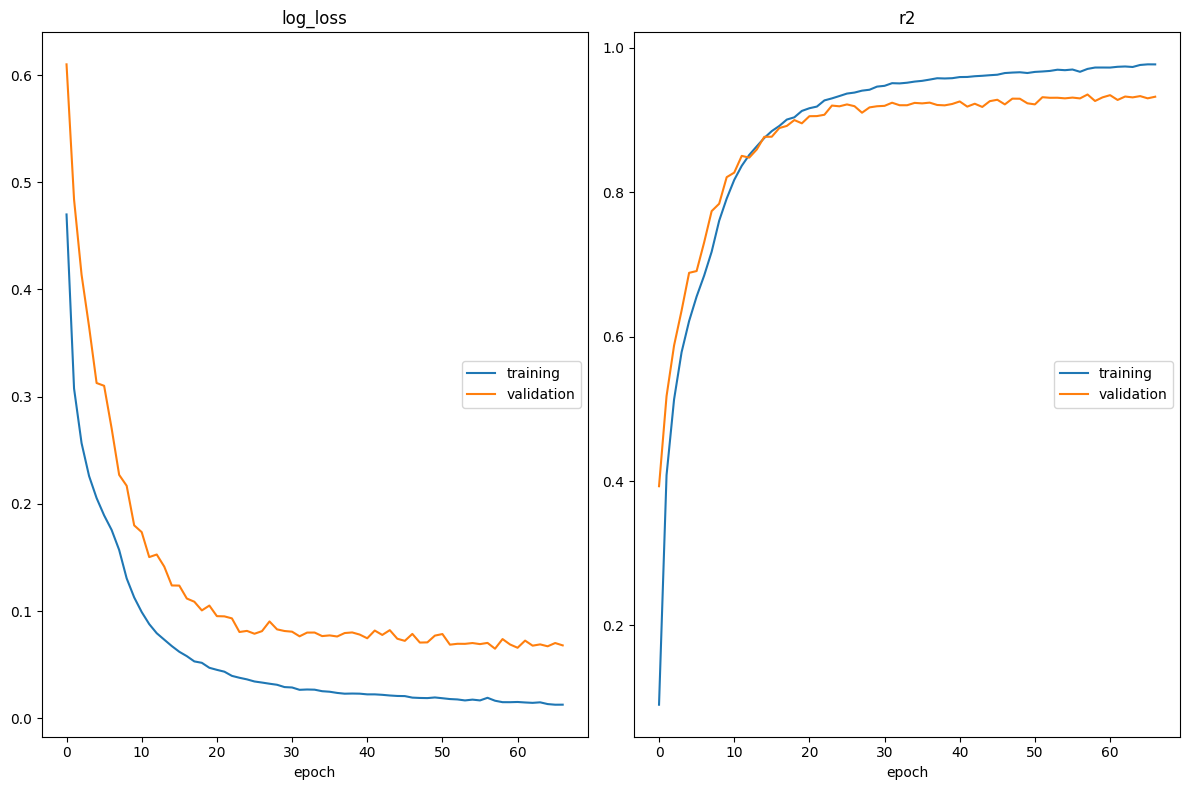

 34%|███▎      | 67/200 [1:56:11<3:28:28, 94.05s/it]

log_loss
	training         	 (min:    0.013, max:    0.470, cur:    0.013)
	validation       	 (min:    0.065, max:    0.610, cur:    0.068)
r2
	training         	 (min:    0.090, max:    0.977, cur:    0.977)
	validation       	 (min:    0.393, max:    0.936, cur:    0.932)


 34%|███▎      | 67/200 [1:57:45<3:53:45, 105.45s/it]

Early stopping: patience limit reached after 67 epochs


In [18]:
patience = 10
best_r2 = -float('inf')
patience_counter = 0

liveloss = PlotLosses()
for epoch in tqdm(range(200)):
    logs = {}
    train_loss, train_r2 = train(model, optimizer, criterion, train_loader, device)
    logs['' + 'log_loss'] = train_loss
    logs['' + 'r2'] = train_r2

    validation_loss, validation_r2 = valid(model, criterion, val_loader, device)
    logs['val_' + 'log_loss'] = validation_loss
    logs['val_' + 'r2'] = validation_r2

    scheduler.step(validation_loss)

    if validation_r2 > best_r2:
        best_r2 = validation_r2
        torch.save(model.state_dict(), model_path + 'pb_trainonall.pth')
        patience_counter = 0
        print(f"Model saved at epoch {epoch}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping: patience limit reached after {epoch} epochs")
            break

    liveloss.update(logs)
    liveloss.draw()

ReservoirDataset containing 100 samples.
Target variable: pressure_buildup
Normalization applied: Yes
Input shape per sample: 96x200 with 24 channels
Target shape per sample: 96x200 with 24 time steps
Files are stored in: /content/drive/MyDrive/GEMS4-CCS/train_data_set
tensor([58])
tensor([39])


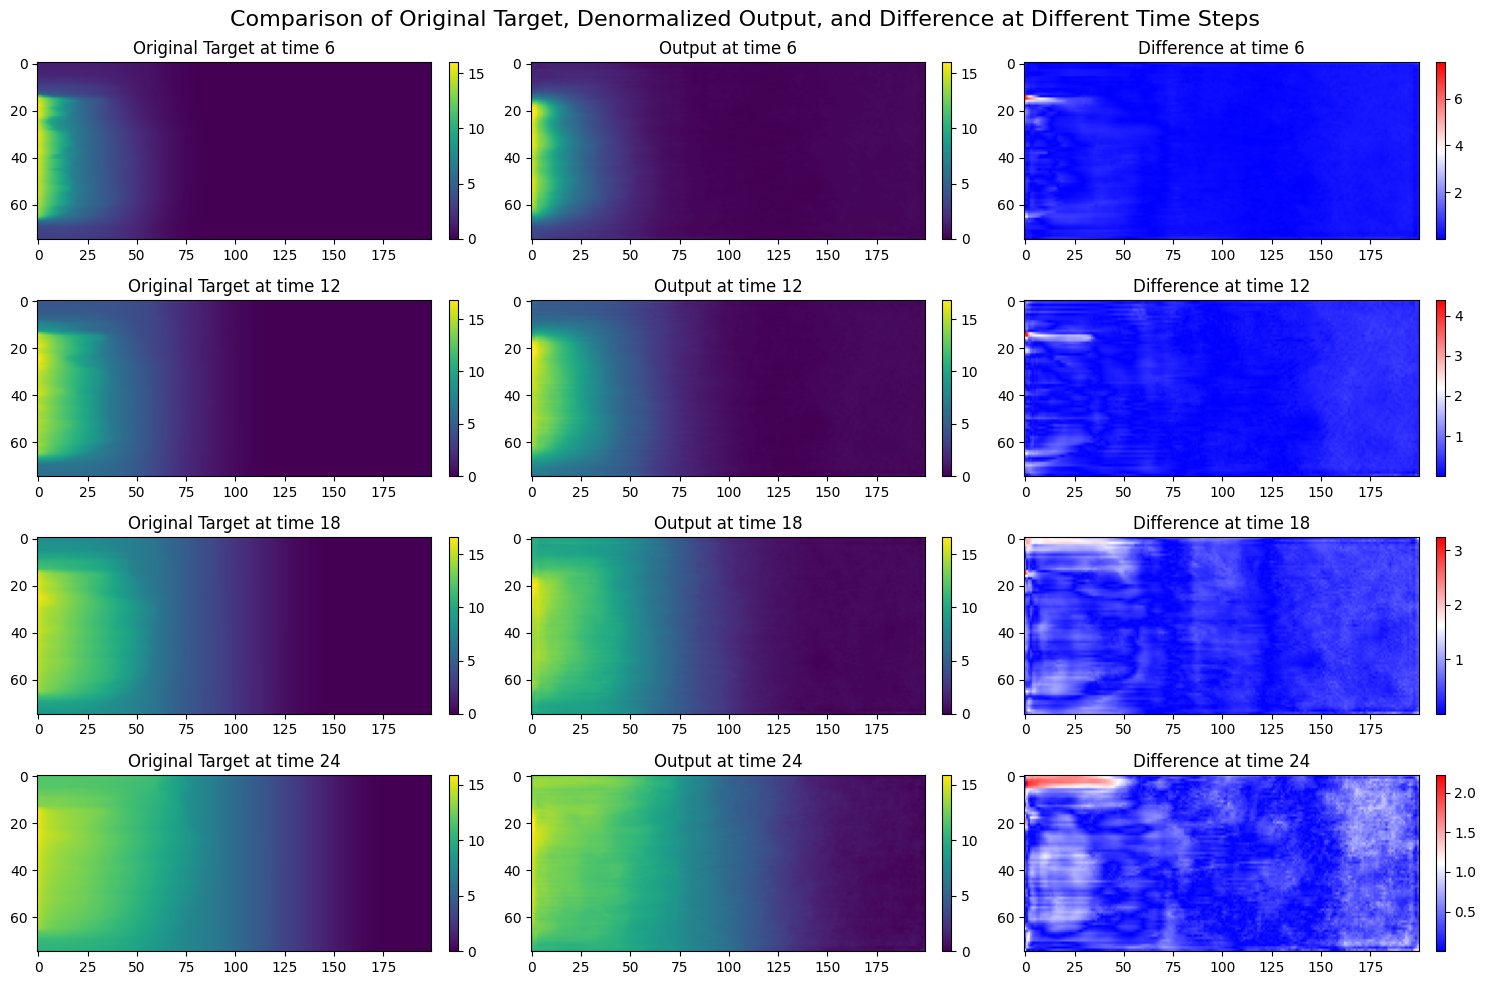

In [19]:

train_data = Preprocessor(split="train", file_num=100, target='pressure_buildup', pad_mode="zero")
print(train_data)

sample_loader = DataLoader(train_data, batch_size=1, shuffle=True)

for data in sample_loader:
    inputs = data["inputs"].numpy()
    target = data["target"].numpy()
    print(data["original_height"])
    break

porosity = inputs[0, 2, :, :]
perm_r = inputs[0, 0, :, :]
perm_z = inputs[0, 1, :, :]
perf_interval = inputs[0, 3, :, :]
temperature = inputs[0, 4, :, :]
gas_saturation = target[0, -1, :, :]

sample_loader = DataLoader(train_data, batch_size=1, shuffle=True)

for data in sample_loader:
    inputs = data["inputs"].numpy()
    target = data["target"].numpy()
    print(data["original_height"])
    break

porosity = inputs[0, 2, :, :]
perm_r = inputs[0, 0, :, :]
perm_z = inputs[0, 1, :, :]
perf_interval = inputs[0, 3, :, :]
temperature = inputs[0, 4, :, :]
gas_saturation = target[0, -1, :, :]


model.load_state_dict(torch.load('/content/drive/MyDrive/GEMS4-CCS/models/pb_trainonall.pth'))
model.to(device)

sample_data = next(iter(sample_loader))
sample_input, sample_target = sample_data["inputs"].to(device), sample_data["target"].to(device)

with torch.no_grad():
    model.eval()
    sample_output = model(sample_input)

height = sample_data["original_height"].item()
original_target = sample_data["original_target"][0, :, :height, :].cpu().numpy()
means = original_target.mean(axis=(1, 2))
stds = original_target.std(axis=(1, 2))

# Denormalize output
def denormalize(normalized_data, mean, std):
    """Reverses the normalization process."""
    return normalized_data * std + mean

output_denormalized = torch.zeros_like(sample_output[0, :, :height, :])
for i in range(output_denormalized.shape[0]):
    output_denormalized[i] = denormalize(sample_output[0, i, :height, :].cpu(), means[i], stds[i])

time_steps = [6, 12, 18, 24]
indices = [step - 1 for step in time_steps]  # Convert to zero-based index

# Set ncols to 3 to include the difference plots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
fig.suptitle('Comparison of Original Target, Denormalized Output, and Difference at Different Time Steps', fontsize=16)

for i, index in enumerate(indices):
    target_img = original_target[index]
    output_img = output_denormalized[index].cpu().detach().numpy()

    # Plot original target
    ax = axes[i, 0]
    im_target = ax.imshow(target_img, aspect='auto', vmin=0, vmax=target_img.max())
    ax.set_title(f'Original Target at time {time_steps[i]}')
    fig.colorbar(im_target, ax=ax, fraction=0.046, pad=0.04)

    # Plot denormalized output
    ax = axes[i, 1]
    im_output = ax.imshow(output_img, aspect='auto', vmin=0, vmax=target_img.max())
    ax.set_title(f'Output at time {time_steps[i]}')
    fig.colorbar(im_output, ax=ax, fraction=0.046, pad=0.04)

    # Plot difference
    ax = axes[i, 2]
    im_diff = ax.imshow(np.abs(target_img - output_img), aspect='auto', cmap='bwr')
    ax.set_title(f'Difference at time {time_steps[i]}')
    fig.colorbar(im_diff, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [21]:
def r2(x, y):
    x = x.flatten()
    y = y.flatten()
    zx = (x-np.mean(x))/np.std(x, ddof=1)
    zy = (y-np.mean(y))/np.std(y, ddof=1)
    r = np.sum(zx*zy)/(len(x)-1)
    return r**2

def MAE(x, y):
    x = x.flatten()
    y = y.flatten()
    return np.mean(np.abs(x - y))

def denormalize(normalized_data, mean, std):
    """Reverses the normalization process."""
    return normalized_data * std + mean

In [22]:
pb_val_dataset = Preprocessor(split="val", target='pressure_buildup', pad_mode='zero')
len(pb_val_dataset)

500

In [24]:
pressure_buildup_r2 = []
pressure_buildup_MAE = []

# Iterate through all samples in the validation dataset
for idx in range(len(pb_val_dataset)):
    with np.load(f'drive/MyDrive/GEMS4-CCS/val_data_set/data_{str(idx).zfill(4)}.npz') as data:
        pressure_buildup = data['pressure_buildup']

    # Retrieve input data correctly from the dataset
    input_data = pb_val_dataset[idx]["inputs"].to(device)
    height = pb_val_dataset[idx]["original_height"]
    original_target = pb_val_dataset[idx]["original_target"]

    means = original_target.mean(axis=(1, 2))
    stds = original_target.std(axis=(1, 2))

    # Get predictions from the model
    with torch.no_grad():
        model.eval()
        sample_output = model(input_data.unsqueeze(0))

    # Denormalize the output
    output_denormalized = torch.zeros_like(sample_output[0, :, :height, :]).to(device)
    for i in range(output_denormalized.shape[0]):
        output_denormalized[i] = denormalize(sample_output[0, i, :height, :], means[i], stds[i])

    # Adjust the shape of the denormalized output for comparison
    output_denormalized = output_denormalized.permute(1, 2, 0).cpu().numpy()

    #print("output", output_denormalized.shape, height)
    #print("data", pressure_buildup.shape)

    # Ensure both arrays are flattened consistently
    pressure_buildup_flat = pressure_buildup.reshape(-1)
    output_denormalized_flat = output_denormalized.reshape(-1)

    # Append R2 and MAE scores using your custom functions
    pressure_buildup_r2.append(r2(pressure_buildup_flat, output_denormalized_flat))
    pressure_buildup_MAE.append(MAE(pressure_buildup_flat, output_denormalized_flat))

# Print the results
print('--------------')
print(f'Average validation set pressure buildup R2 score is: {np.mean(pressure_buildup_r2)}')
print('--------------')
print(f'Average validation set pressure buildup MAE is: {np.mean(pressure_buildup_MAE)}')

--------------
Average validation set pressure buildup R2 score is: 0.9555274248123169
--------------
Average validation set pressure buildup MAE is: 1.3187445402145386
